In [1]:
import os
import mlflow
import optuna
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from copy import deepcopy
from pathlib import Path
from dotenv import load_dotenv
import sys
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import linregress
import powerlaw
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from scipy.stats import norm, entropy, gamma
ColumnTransformer, OneHotEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.outliers import ArbitraryOutlierCapper
from feature_engine.timeseries.forecasting import WindowFeatures
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 8.5

pd.set_option('display.max_columns', None)
# If you want to revert back to the default behavior:
# pd.reset_option('display.max_columns')

sys.path.append('/home/marcos/Github/3w_petrobras/')
from src.load_data import process_metadata
from src.optimizer import ClassifierParameterizer, objective
from src.process_data import preprocess_instances
from src.fft_features import get_fft_to_ids
from src.power_law import fit_powerlaw_to_features

/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
dir_path = os.path.expanduser('~/Github/3w_petrobras/data')
addresses, instances, events, y = process_metadata(dir_path, ['3', '0'])
                    
addresses_train, addresses_test, instances_train, \
instances_test, events_train, events_test,\
y_train, y_test = train_test_split(
    addresses, instances, events, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

data_instances_info = np.column_stack(
    [
        np.concatenate([addresses_train, addresses_test], axis=0),
        np.concatenate([instances_train, instances_test], axis=0),
        np.concatenate([events_train, events_test], axis=0),
        np.concatenate([y_train, y_test], axis=0),
        np.concatenate([['Train']*len(y_train), ['Test']*len(y_test)])
    ]
)

df_metadata = pd.DataFrame(data=data_instances_info, columns=['Address', 'Instance', 'Event', 'Class', 'Set'])
df_metadata['id'] = np.arange(df_metadata.shape[0])
df_metadata.head()

,Address,Instance,Event,Class,Set,id
0,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00067,3,1,Train,0
1,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00041,3,1,Train,1
2,/home/marcos/Github/3w_petrobras/data/0/WELL-0...,WELL-00005_20170817170000,0,0,Train,2
3,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00039,3,1,Train,3
4,/home/marcos/Github/3w_petrobras/data/0/WELL-0...,WELL-00005_20170402230127,0,0,Train,4


In [4]:
df_all = preprocess_instances(df_metadata, periods_undersample=60, positive_event='3')
display(df_all.head())

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,P-PDG__is_missing,P-TPT__is_missing,T-TPT__is_missing,P-MON-CKP__is_missing,T-JUS-CKP__is_missing,P-JUS-CKGL__is_missing,T-JUS-CKGL__is_missing,QGL__is_missing,is_simulated,is_well,id,Address,Instance,Event,Class,Set
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-10 23:49:00,24048050.0,15656440.0,119.3033,10062140.0,90.57189,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,1,0,0,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00067,3,1,Train
2018-04-10 23:50:00,24108100.0,15736100.0,119.2536,10066590.0,90.86570,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,1,0,0,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00067,3,1,Train
2018-04-10 23:51:00,24147830.0,15796550.0,119.2263,10070230.0,91.16160,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,1,0,0,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00067,3,1,Train
2018-04-10 23:52:00,24169110.0,15839570.0,119.2203,10072970.0,91.44675,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,1,0,0,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00067,3,1,Train
2018-04-10 23:53:00,24173070.0,15865880.0,119.2369,10074940.0,91.71573,0.0,0.0,0.0,1,0,0,0,0,0,1,1,1,1,0,0,/home/marcos/Github/3w_petrobras/data/3/SIMULA...,SIMULATED_00067,3,1,Train


# Traning Models

In [5]:
features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
df_fft_all = get_fft_to_ids(df_all, features, df_all['id'].tolist(), window_size=10)
display(df_fft_all.head())

,id,Instance,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase
0,0,SIMULATED_00067,Train,1,0.000005,1.545508e+09,9.496141e+05,1.549244e+09,2.387585,10,0.000005,12377.230656,-4.150096,12379.467385,-0.920983,0.000005,1.040014e+09,21870.883823,1.040021e+09,0.487928,0.000005,9349.563352,-35.515232,9366.834632,-0.847246
1,0,SIMULATED_00067,Train,1,0.000006,-1.923917e+06,1.153319e+06,2.287788e+06,2.620782,10,0.000006,2.997760,-4.417168,5.390204,-1.026555,0.000006,3.852273e+04,26605.215572,4.742351e+04,0.572530,0.000006,31.814989,-37.312999,50.020301,-0.943079
2,0,SIMULATED_00067,Train,1,0.000007,-1.915477e+06,1.340253e+06,2.376437e+06,2.555061,10,0.000007,2.178726,-3.777956,4.364302,-1.052915,0.000007,3.996130e+04,30355.833459,5.075997e+04,0.621936,0.000007,23.110985,-33.073749,40.514170,-0.981455
3,0,SIMULATED_00067,Train,1,0.000007,-1.925340e+06,1.538061e+06,2.500237e+06,2.494720,10,0.000007,1.866689,-3.322575,3.812399,-1.055280,0.000007,4.105742e+04,34476.450967,5.419143e+04,0.671702,0.000007,18.408701,-28.333299,33.840793,-0.987052
4,0,SIMULATED_00067,Train,1,0.000008,-1.947188e+06,1.751512e+06,2.652332e+06,2.437459,10,0.000008,1.725849,-3.033387,3.491858,-1.049092,0.000008,4.205472e+04,39019.728697,5.793306e+04,0.721467,0.000008,15.813073,-24.305449,29.075550,-0.972031


In [6]:
features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
df_powerlaw = fit_powerlaw_to_features(df_fft_all, features)
display(df_powerlaw.head())

/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


,id,Instance,feature,alpha,intercept,r_squared,p_value,std_err
0,0,SIMULATED_00067,P-TPT,1.273595,1.378120,0.680233,2.311255e-128,0.038666
1,0,SIMULATED_00067,T-TPT,1.185020,-4.616456,0.662031,3.166655e-122,0.037492
2,0,SIMULATED_00067,P-MON-CKP,1.021318,0.815801,0.489328,1.898855e-76,0.046201
3,0,SIMULATED_00067,T-JUS-CKP,1.136793,-3.711557,0.719098,1.001159e-142,0.031461
4,1,SIMULATED_00041,P-TPT,2.039646,-1.797355,0.839430,1.071805e-204,0.039501


In [7]:
def merge_data(df1, df2):
    df1_pivot = df1.pivot(index=['id', 'Instance'], columns='feature')
    df1_pivot.columns = ['{}_{}'.format(feature, stat) for stat, feature in df1_pivot.columns]
    df1_pivot.reset_index(inplace=True)
    df_merged = df2.merge(df1_pivot, on=['id', 'Instance'], how='left')
    return df_merged

df_fft_merged = merge_data(df_powerlaw, df_fft_all)

display(df_fft_merged.head())

,id,Instance,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_intercept,P-TPT_intercept,T-JUS-CKP_intercept,T-TPT_intercept,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared,P-MON-CKP_p_value,P-TPT_p_value,T-JUS-CKP_p_value,T-TPT_p_value,P-MON-CKP_std_err,P-TPT_std_err,T-JUS-CKP_std_err,T-TPT_std_err
0,0,SIMULATED_00067,Train,1,0.000005,1.545508e+09,9.496141e+05,1.549244e+09,2.387585,10,0.000005,12377.230656,-4.150096,12379.467385,-0.920983,0.000005,1.040014e+09,21870.883823,1.040021e+09,0.487928,0.000005,9349.563352,-35.515232,9366.834632,-0.847246,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
1,0,SIMULATED_00067,Train,1,0.000006,-1.923917e+06,1.153319e+06,2.287788e+06,2.620782,10,0.000006,2.997760,-4.417168,5.390204,-1.026555,0.000006,3.852273e+04,26605.215572,4.742351e+04,0.572530,0.000006,31.814989,-37.312999,50.020301,-0.943079,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
2,0,SIMULATED_00067,Train,1,0.000007,-1.915477e+06,1.340253e+06,2.376437e+06,2.555061,10,0.000007,2.178726,-3.777956,4.364302,-1.052915,0.000007,3.996130e+04,30355.833459,5.075997e+04,0.621936,0.000007,23.110985,-33.073749,40.514170,-0.981455,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
3,0,SIMULATED_00067,Train,1,0.000007,-1.925340e+06,1.538061e+06,2.500237e+06,2.494720,10,0.000007,1.866689,-3.322575,3.812399,-1.055280,0.000007,4.105742e+04,34476.450967,5.419143e+04,0.671702,0.000007,18.408701,-28.333299,33.840793,-0.987052,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
4,0,SIMULATED_00067,Train,1,0.000008,-1.947188e+06,1.751512e+06,2.652332e+06,2.437459,10,0.000008,1.725849,-3.033387,3.491858,-1.049092,0.000008,4.205472e+04,39019.728697,5.793306e+04,0.721467,0.000008,15.813073,-24.305449,29.075550,-0.972031,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492


In [8]:
def merge_data(df1, df2):
    df1_pivot = df1.pivot(index=['id', 'Instance'], columns='feature')
    df1_pivot.columns = ['{}_{}'.format(feature, stat) for stat, feature in df1_pivot.columns]
    df1_pivot.reset_index(inplace=True)
    df_merged = df2.merge(df1_pivot, on=['id', 'Instance'], how='left')
    return df_merged
df_fft_merged = merge_data(df_powerlaw, df_fft_all)

display(df_fft_merged.head())

,id,Instance,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_intercept,P-TPT_intercept,T-JUS-CKP_intercept,T-TPT_intercept,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared,P-MON-CKP_p_value,P-TPT_p_value,T-JUS-CKP_p_value,T-TPT_p_value,P-MON-CKP_std_err,P-TPT_std_err,T-JUS-CKP_std_err,T-TPT_std_err
0,0,SIMULATED_00067,Train,1,0.000005,1.545508e+09,9.496141e+05,1.549244e+09,2.387585,10,0.000005,12377.230656,-4.150096,12379.467385,-0.920983,0.000005,1.040014e+09,21870.883823,1.040021e+09,0.487928,0.000005,9349.563352,-35.515232,9366.834632,-0.847246,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
1,0,SIMULATED_00067,Train,1,0.000006,-1.923917e+06,1.153319e+06,2.287788e+06,2.620782,10,0.000006,2.997760,-4.417168,5.390204,-1.026555,0.000006,3.852273e+04,26605.215572,4.742351e+04,0.572530,0.000006,31.814989,-37.312999,50.020301,-0.943079,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
2,0,SIMULATED_00067,Train,1,0.000007,-1.915477e+06,1.340253e+06,2.376437e+06,2.555061,10,0.000007,2.178726,-3.777956,4.364302,-1.052915,0.000007,3.996130e+04,30355.833459,5.075997e+04,0.621936,0.000007,23.110985,-33.073749,40.514170,-0.981455,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
3,0,SIMULATED_00067,Train,1,0.000007,-1.925340e+06,1.538061e+06,2.500237e+06,2.494720,10,0.000007,1.866689,-3.322575,3.812399,-1.055280,0.000007,4.105742e+04,34476.450967,5.419143e+04,0.671702,0.000007,18.408701,-28.333299,33.840793,-0.987052,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492
4,0,SIMULATED_00067,Train,1,0.000008,-1.947188e+06,1.751512e+06,2.652332e+06,2.437459,10,0.000008,1.725849,-3.033387,3.491858,-1.049092,0.000008,4.205472e+04,39019.728697,5.793306e+04,0.721467,0.000008,15.813073,-24.305449,29.075550,-0.972031,1.021318,1.273595,1.136793,1.18502,0.815801,1.37812,-3.711557,-4.616456,0.489328,0.680233,0.719098,0.662031,1.898855e-76,2.311255e-128,1.001159e-142,3.166655e-122,0.046201,0.038666,0.031461,0.037492


In [12]:
filter_data = ['id', 'Set', 'P-TPT_frequency', 
                'P-TPT_magnitude', 'T-TPT_frequency',
                'T-TPT_magnitude', 
                'P-MON-CKP_frequency',
                'P-MON-CKP_magnitude',  'T-JUS-CKP_frequency',
                    'T-JUS-CKP_magnitude',
                    'P-MON-CKP_alpha', 'P-TPT_alpha', 'T-JUS-CKP_alpha',
                'T-TPT_alpha', 'P-MON-CKP_r_squared',
                'P-TPT_r_squared', 'T-JUS-CKP_r_squared', 'T-TPT_r_squared', 'Class']



df_fft = df_fft_merged[filter_data]

df_fft_train = df_fft[df_fft['Set'] == 'Train'].copy()
df_fft_test = df_fft[df_fft['Set'] == 'Test'].copy()

df_fft_train.drop(columns=['Set'], inplace=True)
df_fft_test.drop(columns=['Set'], inplace=True)

Y_train = df_fft_train['Class'].values.astype(int)
Y_test = df_fft_test['Class'].values.astype(int)

X_train = df_fft_train.drop(columns=['Class'])
X_test = df_fft_test.drop(columns=['Class'])

display(X_train.head())
display(X_test.head())

,id,P-TPT_frequency,P-TPT_magnitude,T-TPT_frequency,T-TPT_magnitude,P-MON-CKP_frequency,P-MON-CKP_magnitude,T-JUS-CKP_frequency,T-JUS-CKP_magnitude,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared
0,0,0.000005,1.549244e+09,0.000005,12379.467385,0.000005,1.040021e+09,0.000005,9366.834632,1.021318,1.273595,1.136793,1.18502,0.489328,0.680233,0.719098,0.662031
1,0,0.000006,2.287788e+06,0.000006,5.390204,0.000006,4.742351e+04,0.000006,50.020301,1.021318,1.273595,1.136793,1.18502,0.489328,0.680233,0.719098,0.662031
2,0,0.000007,2.376437e+06,0.000007,4.364302,0.000007,5.075997e+04,0.000007,40.514170,1.021318,1.273595,1.136793,1.18502,0.489328,0.680233,0.719098,0.662031
3,0,0.000007,2.500237e+06,0.000007,3.812399,0.000007,5.419143e+04,0.000007,33.840793,1.021318,1.273595,1.136793,1.18502,0.489328,0.680233,0.719098,0.662031
4,0,0.000008,2.652332e+06,0.000008,3.491858,0.000008,5.793306e+04,0.000008,29.075550,1.021318,1.273595,1.136793,1.18502,0.489328,0.680233,0.719098,0.662031


,id,P-TPT_frequency,P-TPT_magnitude,T-TPT_frequency,T-TPT_magnitude,P-MON-CKP_frequency,P-MON-CKP_magnitude,T-JUS-CKP_frequency,T-JUS-CKP_magnitude,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared
191068,562,0.00035,1.998209e+08,0.00035,1417.721437,0.00035,8.820897e+07,0.00035,2077.1532,0.349529,1.57493,16.769985,1.527965,0.080977,0.565567,0.992535,0.467972
191069,562,0.00042,1.240682e+05,0.00042,0.296729,0.00042,4.497205e+05,0.00042,0.0000,0.349529,1.57493,16.769985,1.527965,0.080977,0.565567,0.992535,0.467972
191070,562,0.00049,1.117276e+05,0.00049,0.244299,0.00049,4.840586e+05,0.00049,0.0000,0.349529,1.57493,16.769985,1.527965,0.080977,0.565567,0.992535,0.467972
191071,562,0.00056,9.513797e+04,0.00056,0.217030,0.00056,4.942901e+05,0.00056,0.0000,0.349529,1.57493,16.769985,1.527965,0.080977,0.565567,0.992535,0.467972
191072,562,0.00063,9.275103e+04,0.00063,0.211081,0.00063,5.069171e+05,0.00063,0.0000,0.349529,1.57493,16.769985,1.527965,0.080977,0.565567,0.992535,0.467972


In [14]:
model_parameters_catboost = {
    'learning_rate': {'type': 'float', 'low': 1e-5, 'high': 0.1, 'log': False},
    'depth': {'type': 'int', 'low': 3, 'high': 7},
    'iterations': {'type': 'int', 'low': 100, 'high': 1000},
    'l2_leaf_reg': {'type': 'float', 'low': 0.001, 'high': 1000, 'log': False},
    'random_strength': {'type': 'float', 'low': 0.001, 'high': 1000, 'log': False},
    'subsample': {'type': 'float', 'low': 0.1, 'high': 0.9}
}

categorical_features = ['id']
numerical_features =  [ 'P-TPT_frequency', 
                        'P-TPT_magnitude', 'T-TPT_frequency',
                        'T-TPT_magnitude', 'P-MON-CKP_frequency',
                        'P-MON-CKP_magnitude',  'T-JUS-CKP_frequency',
                        'T-JUS-CKP_magnitude',
                        'P-MON-CKP_alpha', 'P-TPT_alpha', 'T-JUS-CKP_alpha',
                        'T-TPT_alpha', 'P-MON-CKP_r_squared',
                        'P-TPT_r_squared', 'T-JUS-CKP_r_squared', 'T-TPT_r_squared']

# categorical_features = ['id']
# numerical_features =  [ 'P-TPT_frequency', 'P-MON-CKP_frequency','T-TPT_frequency', 'T-JUS-CKP_frequency',
#               'P-MON-CKP_alpha', 'P-TPT_alpha', 'T-JUS-CKP_alpha',
#               'T-TPT_alpha', 'P-MON-CKP_r_squared',
#               'P-TPT_r_squared', 'T-JUS-CKP_r_squared', 'T-TPT_r_squared']



study = optuna.create_study(direction='maximize')  # Here we use 'maximize' because higher F1 is better
study.optimize(lambda trial: objective(trial, X_train, Y_train, 'catboost', model_parameters_catboost, categorical_features, numerical_features), n_trials=5)


[I 2024-10-07 09:37:17,186] A new study created in memory with name: no-name-cac08020-8bd3-494a-9e7c-657881e1aabd
[I 2024-10-07 09:38:31,412] Trial 0 finished with value: 0.9989663592599094 and parameters: {'learning_rate': 0.017048772373735834, 'depth': 7, 'iterations': 819, 'l2_leaf_reg': 212.4438417025056, 'random_strength': 432.3258926881382, 'subsample': 0.2508904260632038}. Best is trial 0 with value: 0.9989663592599094.


Mean Test Accuracy: 0.9990945633563661
Mean Test F1: 0.9989663592599094


[I 2024-10-07 09:38:41,084] Trial 1 finished with value: 0.9639607106287734 and parameters: {'learning_rate': 0.030796175863324955, 'depth': 4, 'iterations': 108, 'l2_leaf_reg': 119.16142020277958, 'random_strength': 480.6028601294008, 'subsample': 0.551245987805692}. Best is trial 0 with value: 0.9989663592599094.


Mean Test Accuracy: 0.9687074648556709
Mean Test F1: 0.9639607106287734


[I 2024-10-07 09:39:56,877] Trial 2 finished with value: 0.9732729577900965 and parameters: {'learning_rate': 0.0018379826363948398, 'depth': 5, 'iterations': 856, 'l2_leaf_reg': 153.27319922637068, 'random_strength': 99.11481554334796, 'subsample': 0.8182368485811428}. Best is trial 0 with value: 0.9989663592599094.


Mean Test Accuracy: 0.9767674354427038
Mean Test F1: 0.9732729577900965


[I 2024-10-07 09:40:22,799] Trial 3 finished with value: 0.9766881061151776 and parameters: {'learning_rate': 0.01507631292552716, 'depth': 3, 'iterations': 367, 'l2_leaf_reg': 278.3032670743108, 'random_strength': 154.05767712836436, 'subsample': 0.5503091834982435}. Best is trial 0 with value: 0.9989663592599094.


Mean Test Accuracy: 0.9796407558933102
Mean Test F1: 0.9766881061151776


[I 2024-10-07 09:41:03,190] Trial 4 finished with value: 0.9992887163589197 and parameters: {'learning_rate': 0.046795199997399874, 'depth': 5, 'iterations': 476, 'l2_leaf_reg': 666.9904722605347, 'random_strength': 153.99369568360223, 'subsample': 0.7712837528691349}. Best is trial 4 with value: 0.9992887163589197.


Mean Test Accuracy: 0.999377184483208
Mean Test F1: 0.9992887163589197


In [15]:
best_params = study.best_params
best_value = study.best_value
trial = study.best_trial

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_value}")

model_parameterizer = ClassifierParameterizer('catboost', model_parameters_catboost)
classifier = model_parameterizer.select_model(**best_params)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

pipeline = make_pipeline(preprocessor, classifier)
pipeline.fit(X_train, Y_train)
Y_train_pred = pipeline.predict(X_train)
Y_test_pred = pipeline.predict(X_test)

acc_train = accuracy_score(Y_train, Y_train_pred)
f1_train = f1_score(Y_train, Y_train_pred)

acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred)

# Registrar métricas
f2_metrics_model = {
    'acc train': acc_train,
    'f1 train': f1_train,
    'mean f1 val': trial.value,
    'acc test': acc_test,
    'f1 test': f1_test,
}

print("\nf2_metrics:\n", f2_metrics_model)

Best parameters: {'learning_rate': 0.046795199997399874, 'depth': 5, 'iterations': 476, 'l2_leaf_reg': 666.9904722605347, 'random_strength': 153.99369568360223, 'subsample': 0.7712837528691349}
Best F1 score: 0.9992887163589197

f2_metrics:
 {'acc train': 0.9995237297715996, 'f1 train': 0.9992644859888622, 'mean f1 val': 0.9992887163589197, 'acc test': 0.9838942886978874, 'f1 test': 0.977196474267842}


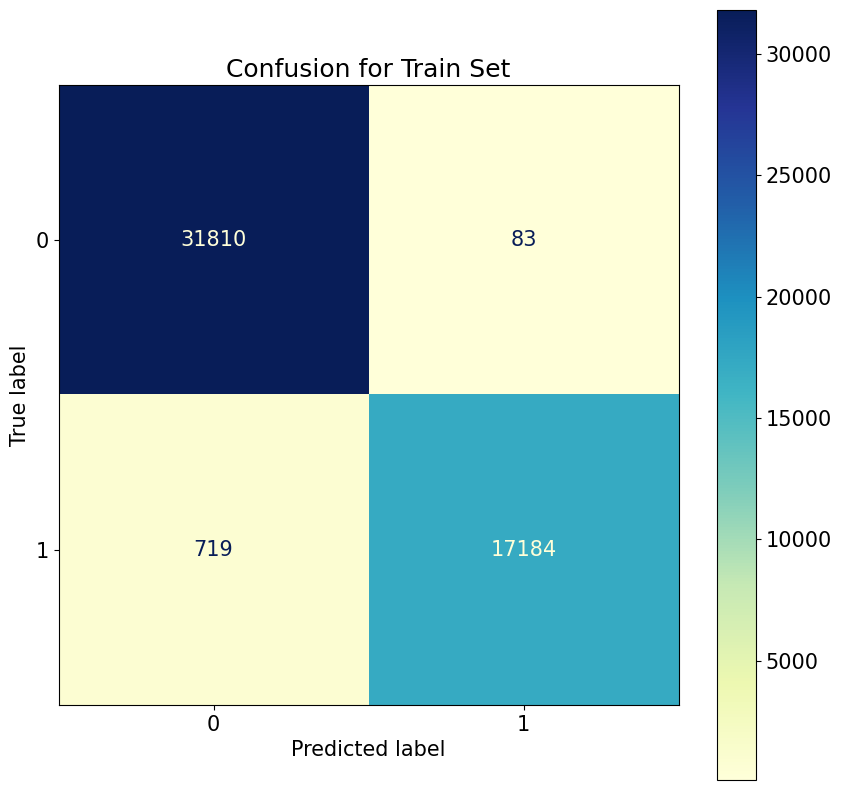

In [16]:
categories = [0, 1]
cm = confusion_matrix(Y_test, Y_test_pred, labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Confusion for Train Set')
disp.plot(ax=ax, cmap="YlGnBu")

In [ ]:
filter_data = ['id', 'Set', 'P-TPT_frequency', 
       'P-TPT_magnitude', 'T-TPT_frequency',
       'T-TPT_magnitude', 
       'P-MON-CKP_frequency',
       'P-MON-CKP_magnitude',  'T-JUS-CKP_frequency',
        'T-JUS-CKP_magnitude',
        'P-MON-CKP_alpha', 'P-TPT_alpha', 'T-JUS-CKP_alpha',
       'T-TPT_alpha', 'P-MON-CKP_r_squared',
       'P-TPT_r_squared', 'T-JUS-CKP_r_squared', 'T-TPT_r_squared', 'Class']

df_fft = df_fft_merged[filter_data]
df_fft_train = df_fft[df_fft['Set'] == 'Train'].copy()
df_fft_test = df_fft[df_fft['Set'] == 'Test'].copy()

df_fft_train.drop(columns=['Set'], inplace=True)
df_fft_test.drop(columns=['Set'], inplace=True)

Y_train = df_fft_train['Class'].values.astype(int)
Y_test = df_fft_test['Class'].values.astype(int)

X_train = df_fft_train.drop(columns=['Class'])
X_test = df_fft_test.drop(columns=['Class'])

catboost_all_features = joblib.load('models/catboost_magnitudes_powerlaw.joblib')
Y_test_pred = catboost_all_features.predict(X_test)

# get confusion matrix (train set)
categories = [0, 1]
cm = confusion_matrix(Y_test, Y_test_pred, labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Confusion for Train Set')
disp.plot(ax=ax, cmap="YlGnBu")